## Data Exploration Project - PSYC 5270

Damien Chambon - Yash Kalburgi

### Data loading

In [1]:
import os
import glob
import numpy as np
from time import sleep #prevents exceeding data rate limit
from IPython.display import clear_output
import matplotlib.pyplot as plt

def read_stimuli(path):
    # This function reads the different stimuli that a neuron has been tested with
    # path: folder where the different stimuli are located
    arraySpikes = []
    listFiles = os.listdir(path) # dir is your directory path
    number_files = len(listFiles)
    
    print(path) # print the folder being read
    
    for i in range(int(number_files/2)):
        # for each stimuli, read the list of spikes and the file name where it is located
        if os.name == 'nt':
            # for Windows
            pathSpike = path + "\\spike" + str(i+1)
            pathStim = path + "\\stim" + str(i+1)
        else:
            pathSpike = path + "/spike" + str(i+1)
            pathStim = path + "/stim" + str(i+1)
        listOfSpikes = []
        with open(pathSpike, "rt") as fp:
            # read the array of spikes
            listOfSpikes = ([np.fromstring(line, sep=" ") for line in fp])
        with open(pathStim) as f:
            # read the file name
            nameStim = f.readline()
        arraySpikes.append({"filename": nameStim, "seriesSpikes": listOfSpikes})
    return arraySpikes

def read_area(path):
# This function reads the different neurons of different areas in the brain
# path: folder where the different areas are located
    arrayNeur = []
    for neuronName in os.listdir(path):
        if neuronName != ".DS_Store":
            # for each neuron in the folder
            if os.name == 'nt':
                # for Windows
                arrayFolder = glob.glob(path+"\\"+neuronName+"\\"+"*")
            else:
                arrayFolder = glob.glob(path+"/"+neuronName+"/"+"*")
                listTypes = []
                for folder in arrayFolder:
                    # get the list of the types of stimuli that the neuron was tested with
                    if os.name == 'nt':
                        # for Windows
                        listTypes.append(folder[len(path+"\\"+neuronName+"\\"):])
                    else:
                        listTypes.append(folder[len(path+"/"+neuronName+"/"):])
                arrayStimuli = []
                for t in listTypes:
                    # for each type in the list, read the spikes generated and the stimuli tested
                    if os.name == 'nt':
                        # for Windows
                        arraySpikes = read_stimuli(path+"\\"+neuronName+"\\"+t)
                    else:
                        arraySpikes = read_stimuli(path+"/"+neuronName+"/"+t)
                    arrayStimuli.append({"type": t, "spikes": arraySpikes})
                arrayNeur.append({"name": neuronName, "stimuli": arrayStimuli})
    return arrayNeur

listAreas = ["Field_L_cells","MLd_cells"] # list of areas to get the data from

if os.name == 'nt':
    # for Windows
    currentDir = os.getcwd()+"\\data\\crcns-aa1" # find the folder where the data is located
else:
    currentDir = os.getcwd()+"/data/crcns-aa1" # find the folder where the data is located

arrayAreas = []
for area in listAreas:
    # read each folder of each area
    if os.name == 'nt':
        # for Windows
        arrayNeurons = read_area(currentDir + "\\" + area)
    else:
        arrayNeurons = read_area(currentDir + "/" + area)
    arrayAreas.append({"name": area, "neurons": arrayNeurons})

sleep(1.5) # keep output for some time    
clear_output()
print("Loading of the data done!")

Loading of the data done!


### Raster plot

Neuron yg0616_8_B in the Auditory Pallial region


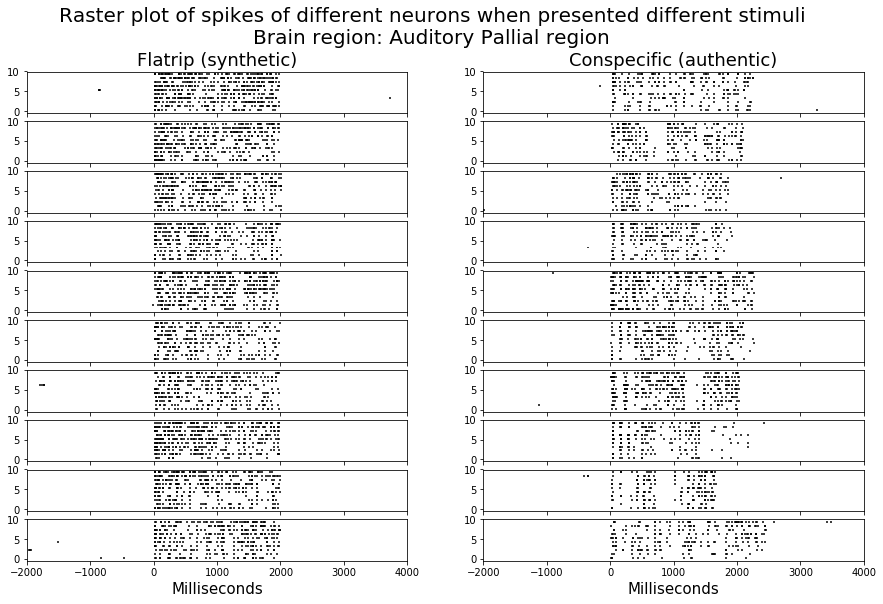

Neuron pipu0617_6_A in the Mesencephalicus Lateralis Dorsalis


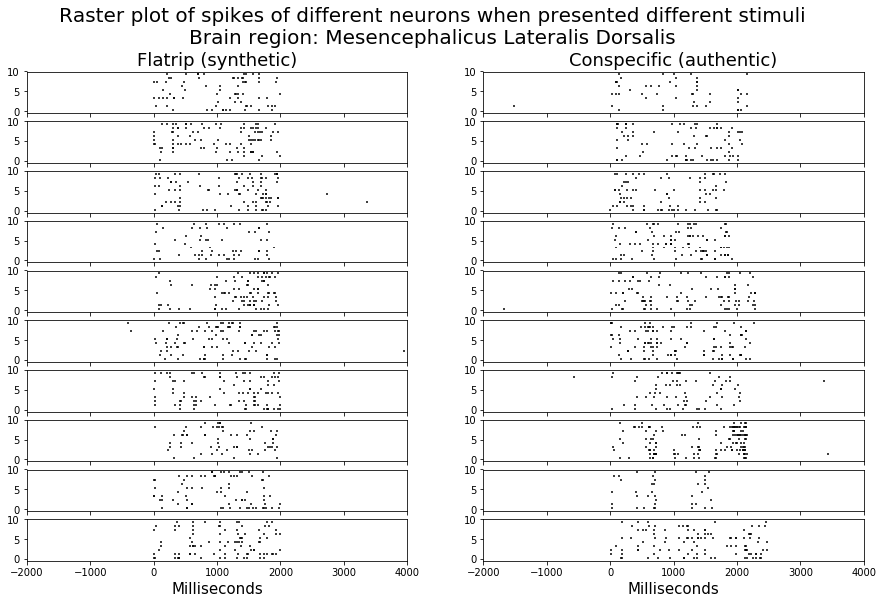

In [4]:
import src.graphics as graphics

def build_rasterplot(spikes_neuron, name_Area):
    # function to build a raster plot based on spikes of a neuron
    # parameters:
    # spikes_neuron: list of spikes produced by the neuron
    # name_Area: name of the brain region where the neuron is located
    nb_flatrip = len(spikes_neuron[0]["spikes"]) # number of synthetic stimuli presented to the neuron
    nb_conspecific = len(spikes_neuron[1]["spikes"]) # number of authentic stimuli presented to the neuron
    min_nb_stim = min(nb_conspecific,nb_flatrip)
    
    fig, axes = plt.subplots(nrows=min_nb_stim, ncols=2, sharex=True, figsize=(15, 9))

    for (m,n), subplot in np.ndenumerate(axes):
        # code inspired by https://stackoverflow.com/questions/31006971/setting-the-same-axis-limits-for-all-subplots-in-matplotlib/31007233
        subplot.set_xlim(-2000,4000) # sets the xlim between -2000 and 4000
        if m == 0:
            if n == 0:
                subplot.set_title("Flatrip (synthetic)",fontsize=18) # sets the title of left column
            else:
                subplot.set_title("Conspecific (authentic)",fontsize=18) # sets the title of left column
        if m == (min_nb_stim-1):
            subplot.set_xlabel("Milliseconds",fontsize=15) # sets the title of left column

    index_stimuli = 0
    while index_stimuli < min_nb_stim:
        # flatrip is white noise (synthetic)
        spikes_flatrip = spikes_neuron[0]["spikes"][index_stimuli]["seriesSpikes"]
        graphics.plot_raster(axes[index_stimuli][0],spikes_flatrip)
        # conspecific is authentic sound
        spikes_conspecific = spikes_neuron[1]["spikes"][index_stimuli]["seriesSpikes"]
        graphics.plot_raster(axes[index_stimuli][1],spikes_conspecific)
        index_stimuli+=1
    fig.suptitle('Raster plot of spikes of different neurons when presented different stimuli\nBrain region: '+name_Area,fontsize=20)
    plt.show()
        

listNeurons_field_l_neuron1 = arrayAreas[0]["neurons"][31]["stimuli"]
name_field_l = "Auditory Pallial region"
print("Neuron",arrayAreas[0]["neurons"][31]["name"],"in the",name_field_l)
build_rasterplot(listNeurons_field_l_neuron1,name_field_l)
# for neuron in area n°0, neuron n°10 = very noisy raster plot but not significant distance matrix

listNeurons_mld_neuron1 = arrayAreas[1]["neurons"][1]["stimuli"]
name_mld = "Mesencephalicus Lateralis Dorsalis"
print("Neuron",arrayAreas[1]["neurons"][1]["name"],"in the",name_mld)
build_rasterplot(listNeurons_mld_neuron1,name_mld)

### Distance matrix

In [6]:
import pyspike as spk
from pyspike import SpikeTrain

def create_distance_matrix(spikes_neuron, name_Area):
    # function to create the distance matrix of the spikes produced by a neuron when presented different stimuli
    # parameters:
    # spikes_neuron: list of spikes produced by the neuron
    # name_Area: name of the brain region where the neuron is located
    list_spikes = []
    max_interval = 4000.0
    
    nb_flatrip = len(spikes_neuron[0]["spikes"]) # number of synthetic stimuli presented to the neuron
    nb_conspecific = len(spikes_neuron[1]["spikes"]) # number of authentic stimuli presented to the neuron
    min_nb_stim = min(nb_conspecific,nb_flatrip)

    spike_trains_flatrip = spikes_neuron[0]["spikes"]
    # iterate through spikes for flatrip (synthetic stimuli)
    # and add them to the list of spikes for the distance matrix
    for i in range(min_nb_stim):
        for spike in spike_trains_flatrip[i]["seriesSpikes"]:
            new_spike_train = SpikeTrain(spike,[0.0, max_interval])
            list_spikes.append(new_spike_train)
  
    spike_trains_conspecific = spikes_neuron[1]["spikes"]
    # iterate through spikes for conspecific (authentic stimuli)
    # and add them to the list of spikes for the distance matrix
    for i in range(min_nb_stim):
        for spike in spike_trains_conspecific[i]["seriesSpikes"]:
            new_spike_train = SpikeTrain(spike,[0.0,max_interval])
            list_spikes.append(new_spike_train)

    plt.figure()
    spike_distance = spk.spike_distance_matrix(list_spikes,interval=(0,max_interval)) # compute distances between all the trials
    plt.imshow(spike_distance, interpolation='none')
    plt.colorbar()
    plt.title("SPIKE-distance of " + str(min_nb_stim*2) + " stimuli presented to\nneurons in the " + name_Area + " brain region")
    print(spike_distance)
    plt.show()

create_distance_matrix(listNeurons_field_l_neuron1,name_field_l)
create_distance_matrix(listNeurons_mld_neuron1,name_mld)

ModuleNotFoundError: No module named 'src.pyspike'

### Spike Rates

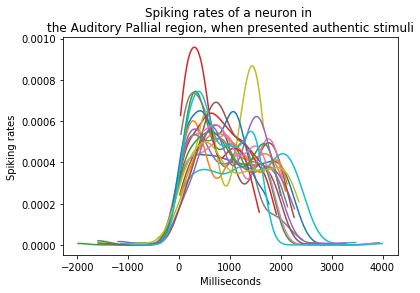

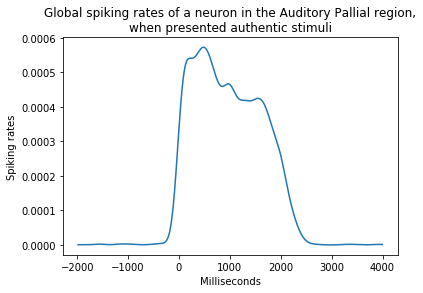

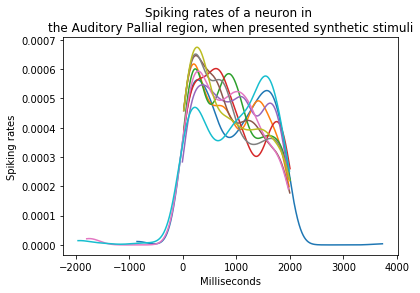

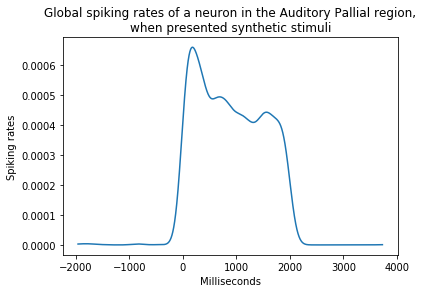

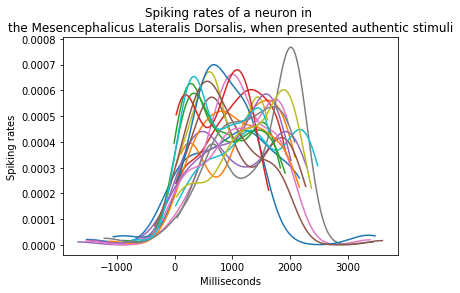

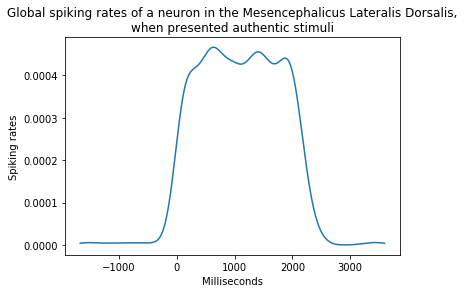

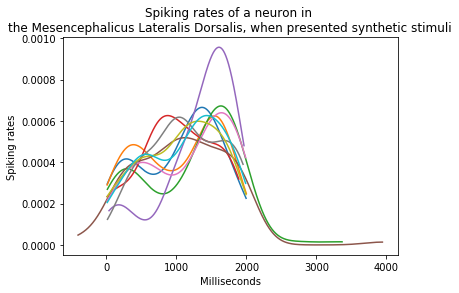

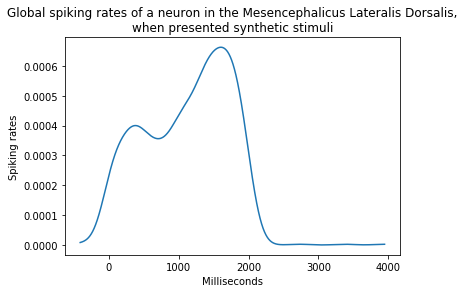

In [7]:
from scipy.stats.kde import gaussian_kde

def plot_density_function(spikes_neuron, name_Area):
    # code inspired by https://stackoverflow.com/questions/15415455/plotting-probability-density-function-by-sample-with-matplotlib
    # function to plot the probability density function (rates) of the spikes for 1) different stimuli of the same type 2) the global spikes (across trials and stimuli) per category of stimuli
    # parameters:
    # spikes_neuron: list of spikes produced by the neuron
    # name_Area: name of the brain region where the neuron is located
    
    nb_flatrip = len(spikes_neuron[0]["spikes"]) # number of synthetic stimuli presented to the neuron
    nb_conspecific = len(spikes_neuron[1]["spikes"]) # number of authentic stimuli presented to the neuron
    spike_trains_conspecific = spikes_neuron[1]["spikes"]
    spike_trains_flatrip = spikes_neuron[0]["spikes"]
    
    ### rate of the conspecific stimuli for the different neurons ###
    final_arr_conspecific = [] # list containing all the spikes for all the trials of all the conspecific stimuli
    for i in range(nb_conspecific): 
        spikes = spike_trains_conspecific[i]["seriesSpikes"]
        arr_spikes = [] # list containing all the spikes for all the trials of the specific conspecific stimulus
        for spike in spikes:
            arr_spikes = np.concatenate((arr_spikes,spike))
            final_arr_conspecific = np.concatenate((final_arr_conspecific,spike))
        arr_spikes.sort()
        # create the PDF of the rates for the specific stimulus
        start_support_cons = arr_spikes[0]
        end_support_cons = arr_spikes[len(arr_spikes)-1]
        support_cons = np.arange(start_support_cons, end_support_cons, 0.1)
        kde_cons = gaussian_kde(arr_spikes)
        plt.plot(support_cons,kde_cons(support_cons))
    plt.xlabel("Milliseconds")
    plt.ylabel("Spiking rates")
    plt.title("Spiking rates of a neuron in \nthe "+name_Area + ", when presented authentic stimuli")
    plt.show()

    # create the PDF of the rates for the conspecific stimuli 
    final_arr_conspecific.sort()
    start_support_cons_final = final_arr_conspecific[0]
    end_support_cons_final = final_arr_conspecific[len(final_arr_conspecific)-1]
    support_cons_final = np.arange(start_support_cons_final, end_support_cons_final, 0.1)
    kde_cons_final = gaussian_kde(final_arr_conspecific)
    plt.plot(support_cons_final,kde_cons_final(support_cons_final))
    plt.xlabel("Milliseconds")
    plt.ylabel("Spiking rates")
    plt.title("Global spiking rates of a neuron in the "+ name_Area + ",\nwhen presented authentic stimuli")
    plt.show()

    ### rate of the flatrip stimuli for the different neurons ###
    final_arr_flatrip = [] # list containing all the spikes for all the trials of all the flatrip stimuli
    for i in range(nb_flatrip): 
        spikes = spike_trains_flatrip[i]["seriesSpikes"]
        arr_spikes = [] # list containing all the spikes for all the trials of the specific conspecific stimulus
        for spike in spikes:
            arr_spikes = np.concatenate((arr_spikes,spike))
            final_arr_flatrip = np.concatenate((final_arr_flatrip,spike))
        arr_spikes.sort()
        # create the PDF of the rates for the specific stimulus
        start_support_flat = arr_spikes[0]
        end_support_flat = arr_spikes[len(arr_spikes)-1]
        support_flat = np.arange(start_support_flat, end_support_flat, 0.1)
        kde_flat = gaussian_kde(arr_spikes)
        plt.plot(support_flat,kde_flat(support_flat))
    plt.xlabel("Milliseconds")
    plt.ylabel("Spiking rates")
    plt.title("Spiking rates of a neuron in \nthe "+name_Area + ", when presented synthetic stimuli")
    plt.show()

    # create the PDF of the rates for the conspecific stimuli 
    final_arr_flatrip.sort()
    start_support_flat_final = final_arr_flatrip[0]
    end_support_flat_final = final_arr_flatrip[len(final_arr_flatrip)-1]
    support_flat_final = np.arange(start_support_flat_final, end_support_flat_final, 0.1)
    kde_flat_final = gaussian_kde(final_arr_flatrip)
    plt.plot(support_flat_final,kde_flat_final(support_flat_final))
    plt.xlabel("Milliseconds")
    plt.ylabel("Spiking rates")
    plt.title("Global spiking rates of a neuron in the "+ name_Area + ",\nwhen presented synthetic stimuli")
    plt.show()
    
    return final_arr_conspecific, final_arr_flatrip
    
final_arr_consp_field_l, final_arr_flat_field_l = plot_density_function(listNeurons_field_l_neuron1,name_field_l)
final_arr_consp_mld, final_arr_flat_mld = plot_density_function(listNeurons_mld_neuron1,name_mld)

### Mutual Information

The difference in means of spike times between the rates of a neuron from the Auditory Pallial region when presented stimuli synthetic vs. authentic is equal to 0.10764803719875463
The difference in means of spike times between the rates of a neuron from the Mesencephalicus Lateralis Dorsalis region when presented stimuli synthetic vs. authentic is equal to -0.033131315748291465


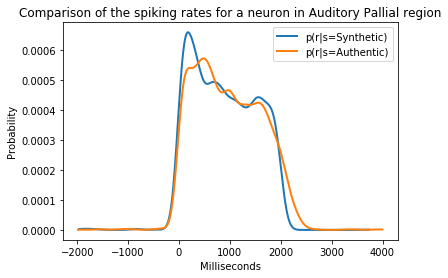

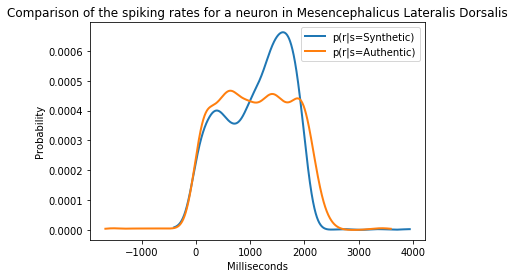

In [8]:
def get_d_prime(arr_consp, arr_flatrip):
    # function to plot the get the difference in means between two arrays of spike times
    # parameters:
    # arr_consp: list of spikes produced by the neuron for conspecific stimuli
    # arr_flatrip: list of spikes produced by the neuron for flatrip stimuli
    mean_consp = np.mean(arr_consp)
    mean_flat = np.mean(arr_flatrip)
    global_array = np.concatenate((arr_consp,arr_flatrip)) # global array containing all the spike times
    std_global = np.std(global_array)
    d_prime = (mean_consp-mean_flat)/std_global
    return d_prime

print("The difference in means of spike times between the rates of a neuron from the Auditory Pallial region when presented stimuli synthetic vs. authentic is equal to", get_d_prime(final_arr_consp_field_l,final_arr_flat_field_l))
print("The difference in means of spike times between the rates of a neuron from the Mesencephalicus Lateralis Dorsalis region when presented stimuli synthetic vs. authentic is equal to", get_d_prime(final_arr_consp_mld,final_arr_flat_mld))

def compare_distrib(arr_consp, arr_flatrip,area_name):
    # function to plot the spike rates of a neuron when presented conspecific and authentic stimuli
    # parameters:
    # arr_consp: list of spikes produced by the neuron for conspecific stimuli
    # arr_flatrip: list of spikes produced by the neuron for flatrip stimuli
    # area_name: the name of the area where the neuron is located
    
    # spike rates for flatrip stimuli
    start_support_flat = arr_flatrip[0]
    end_support_flat = arr_flatrip[len(arr_flatrip)-1]
    support_flat = np.arange(start_support_flat, end_support_flat, 0.1)
    kde_flat = gaussian_kde(arr_flatrip)

    # spike rates for conspecific stimuli
    start_support_consp = arr_consp[0]
    end_support_consp = arr_consp[len(arr_consp)-1]
    support_consp = np.arange(start_support_consp, end_support_consp, 0.1)
    kde_consp = gaussian_kde(arr_consp)

    plt.plot(support_flat, kde_flat(support_flat), lw=2, label="p(r|s=Synthetic)")
    plt.plot(support_consp, kde_consp(support_consp), lw=2, label="p(r|s=Authentic)")
    plt.legend()
    plt.xlabel("Milliseconds")
    plt.ylabel("Probability")
    plt.title("Comparison of the spiking rates for a neuron in " + area_name)
    plt.show()
    
compare_distrib(final_arr_consp_field_l,final_arr_flat_field_l,name_field_l)
compare_distrib(final_arr_consp_mld,final_arr_flat_mld,name_mld)  